In [1]:
!pip install accelerate peft flash-attn arize-phoenix-evals pycm vllm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 90.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.3/264.3 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━

In [2]:
from phoenix.evals import download_benchmark_dataset
import pandas as pd
df = download_benchmark_dataset(
    task="binary-hallucination-classification", dataset_name="halueval_qa_data"
)
df.head()

,reference,query,response,is_hallucination
0,() is a prefecture-level city in northweste...,Can Fuyang and Gaozhou be found in the same p...,no,False
1,() is a prefecture-level city in northweste...,Can Fuyang and Gaozhou be found in the same p...,"Yes, Fuyang and Gaozhou are in the same province.",True
2,"""808"" was a success in the United States beco...",808 peaked at number eight on what?,"Billboard"" Hot 100",False
3,"""808"" was a success in the United States beco...",808 peaked at number eight on what?,"""808"" peaked at number nine on ""Billboard"" Hot...",True
4,"""Arms"" then made a comeback in 2017 reaching ...",Arms is a song by American singer-songwriter C...,Moana,False


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

N_EVAL_SAMPLE_SIZE = 200

# Ensure N_EVAL_SAMPLE_SIZE is even
if N_EVAL_SAMPLE_SIZE % 2 != 0:
    N_EVAL_SAMPLE_SIZE += 1

# Split the dataframe into two based on is_hallucinated
df_true = df[df['is_hallucination'] == True]
df_false = df[df['is_hallucination'] == False]

# Sample equal numbers from each
n_each = N_EVAL_SAMPLE_SIZE // 2
df_true_sampled = df_true.sample(n=n_each, random_state=42)
df_false_sampled = df_false.sample(n=n_each, random_state=42)

# Combine the sampled dataframes
df_balanced = pd.concat([df_true_sampled, df_false_sampled])

# Shuffle the combined dataframe
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Rename columns
df_balanced = df_balanced.rename(columns={"query": "input", "response": "output"})

print(f"Total samples: {len(df_balanced)}")
print(f"True samples: {sum(df_balanced['is_hallucination'])}")
print(f"False samples: {sum(~df_balanced['is_hallucination'])}")

Total samples: 200
True samples: 100
False samples: 100


In [4]:
df_balanced['is_hallucination'] = df_balanced['is_hallucination'].astype(int)
df_balanced.head()

,reference,input,output,is_hallucination
0,"""Tourist Trapped"" is the first episode of the ...","What types of media would these be seen on, Te...",Both can be seen in theaters.,1
1,"Jake Davis (born July 20, 1992) is a singer-so...",Where was the musician who Jake Davis first ga...,The musician who Jake Davis first gained recog...,1
2,"Born in Stroud, Oklahoma, he played collegiat...",Kevin Bookout played college basketball that p...,Kevin Bookout played college basketball that u...,1
3,"The Walloon Legion served in the Wehrmacht, l...","Walloon Legion, a collaborationist volunteer u...",World War II,0
4,Life in the Undergrowth is a BBC nature docume...,Are Life in the Undergrowth and Feiyu Show bot...,yes,0


In [5]:
#shuffle df
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
len(df_balanced)

200

In [6]:
from peft import PeftModel, PeftConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import pipeline
import torch

# base_model_id = "Jlonge4/phi4-phi3.5-distil"
# groundedai_eval_id = "Jlonge4/outputs"

# if torch.cuda.is_bf16_supported():
#   compute_dtype = torch.bfloat16
#   attn_implementation = 'flash_attention_2'
# # If bfloat16 is not supported, 'compute_dtype' is set to 'torch.float16' and 'attn_implementation' is set to 'sdpa'.
# else:
#   compute_dtype = torch.float16
#   attn_implementation = 'sdpa'

# # config = PeftConfig.from_pretrained(groundedai_eval_id)
# base_model = AutoModelForCausalLM.from_pretrained(base_model_id, attn_implementation=attn_implementation,torch_dtype=compute_dtype).to('cuda')
# # model_peft = PeftModel.from_pretrained(base_model, groundedai_eval_id, config=config)

# tokenizer = AutoTokenizer.from_pretrained(base_model_id)

# merged_model = model_peft.merge_and_unload()
# merged_model.to('cuda')

In [7]:
def format_func(reference, query, response):
    prompt = f"""Your job is to evaluate whether a machine learning model has hallucinated or not.
  A hallucination occurs when the response is coherent but factually incorrect or nonsensical
  outputs that are not grounded in the provided context.
  You are given the following information:
      ####INFO####
      [Knowledge]: {reference}
      [User Input]: {query}
      [Model Response]: {response}
      ####END INFO####
      Based on the information provided is the model output a hallucination?
      """
    return prompt

In [8]:
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>

Be concise within the answer tags, providing yes or no for your classification only.
"""

In [9]:
torch.cuda.empty_cache()
import gc
gc.collect()

30

In [32]:
from vllm import LLM, SamplingParams
from tqdm import tqdm

def run_merged_model_batch(df, batch_size=20):
    """
    Process DataFrame in batches using VLLM
    """
    # Initialize VLLM
    llm = LLM(
        model="microsoft/Phi-3.5-mini-instruct",#"Jlonge4/phi4-phi3.5-distil",
        max_num_seqs=batch_size,
        max_model_len=2048,
        tensor_parallel_size=1,
        gpu_memory_utilization=0.9,
    )

    sampling_params = SamplingParams(
        temperature=0.3,
        top_p=0.3,
        stop=["</answer>"],
        max_tokens=756,
    )

    tokenizer = AutoTokenizer.from_pretrained("Jlonge4/phi4-phi3.5-distil")
    all_predictions = []

    # Process in batches with progress bar
    for i in tqdm(range(0, len(df), batch_size)):
        batch = df.iloc[i:i + batch_size]

        # Format inputs for batch
        prompts = []
        for _, row in batch.iterrows():
            messages = [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": format_func(row['reference'], row['input'], row['output'])}
            ]
            chat_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
            prompts.append(chat_text)

        # Generate outputs using VLLM
        outputs = llm.generate(prompts, sampling_params)
        predictions = [output.outputs[0].text.strip().lower() for output in outputs]
        all_predictions.extend(predictions)

    return all_predictions

# Usage:
df_balanced['predictions'] = run_merged_model_batch(df_balanced)

INFO 02-20 13:35:52 config.py:137] Replacing legacy 'type' key with 'rope_type'
INFO 02-20 13:35:54 config.py:542] This model supports multiple tasks: {'embed', 'score', 'generate', 'classify', 'reward'}. Defaulting to 'generate'.
INFO 02-20 13:35:54 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='microsoft/Phi-3.5-mini-instruct', speculative_config=None, tokenizer='microsoft/Phi-3.5-mini-instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, col

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 02-20 13:35:59 model_runner.py:1115] Loading model weights took 7.1176 GB
INFO 02-20 13:36:00 worker.py:267] Memory profiling takes 0.47 seconds
INFO 02-20 13:36:00 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.90) = 35.60GiB
INFO 02-20 13:36:00 worker.py:267] model weights take 7.12GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 0.13GiB; the rest of the memory reserved for KV Cache is 28.36GiB.
INFO 02-20 13:36:00 executor_base.py:110] # CUDA blocks: 4839, # CPU blocks: 682
INFO 02-20 13:36:00 executor_base.py:115] Maximum concurrency for 2048 tokens per request: 37.80x
INFO 02-20 13:36:00 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_util

Capturing CUDA graph shapes: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]

INFO 02-20 13:36:05 model_runner.py:1562] Graph capturing finished in 5 secs, took 0.03 GiB
INFO 02-20 13:36:05 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 6.24 seconds



100%|██████████| 10/10 [00:54<00:00,  5.47s/it]


In [33]:
df_balanced_ = df_balanced.copy()
df_balanced_['predictions'].iloc[4]

'<reasoning>\nthe provided information states that conrad, a member of the hohenstaufen dynasty, served as regent of jerusalem on two occasions. the model response, however, claims that john of arsuf was never a regent. there is no mention of john of arsuf in the provided information, and the response introduces a new character without any basis in the given context.\n</reasoning>\n<answer>\nyes, the model output is a hallucination.'

In [34]:
df_balanced_v2 = df_balanced_.copy()
df_balanced_v2['predictions']

,predictions
0,<reasoning>\nthe model response is directly re...
1,<reasoning>\nthe model response indicates that...
2,<reasoning>\nthe provided information states t...
3,<reasoning>\nthe model's response indicates th...
4,<reasoning>\nthe provided information states t...
...,...
195,<reasoning>\nthe model response correctly iden...
196,<reasoning>\nthe model response correctly stat...
197,<reasoning>\nthe model response correctly iden...
198,<reasoning>\nthe model response is factually c...


In [35]:
df_balanced_['predictions'] = (
    df_balanced['predictions']
    .str.split('<answer>')
    .str[-1]  # get everything after last <answer> tag
    .str.strip()
    .str.lower()
    .apply(lambda x: 'yes' if 'yes' in x else 'no' if 'no' in x else x)
)

In [36]:
df_balanced_.head()

,reference,input,output,is_hallucination,predictions
0,The technique is most closely associated with...,The horse-collar tackle technique is most clos...,University of Oklahoma,0,no
1,Lysiloma is a genus of flowering plants in the...,Are both Lysiloma and Peltophorum large tree s...,no,0,yes
2,"Dominant tree species include koa (""Acacia ko...",Hawaiian tropical dry forests have a dominant ...,Hawaiian tropical dry forests have a dominant ...,1,no
3,YM was an American teen magazine that began in...,Which magazine YM or Midwest Living was founde...,"Midwest Living, by several years.",1,yes
4,He served as regent of Jerusalem on two occas...,John of Arsuf was the regent of Jerusalem unde...,John of Arsuf was never a regent.,1,yes


In [37]:
len(df_balanced['predictions'])
PREDICTION_MAP = {"no": 0, "yes": 1}

In [38]:
unique_predictions = df_balanced_['predictions'].unique()
unique_predictions

array(['no', 'yes'], dtype=object)

In [39]:
PREDICTION_MAP = {
    "yes": 1,
    "no": 0
}

#Distilled model

              precision    recall  f1-score   support

           0       0.72      0.94      0.81       100
           1       0.91      0.63      0.75       100

    accuracy                           0.79       200
   macro avg       0.82      0.78      0.78       200
weighted avg       0.82      0.79      0.78       200



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

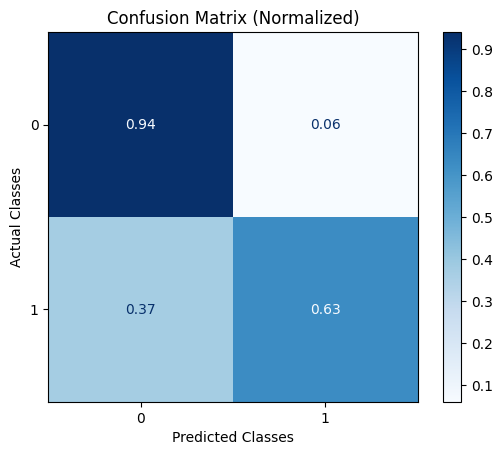

In [40]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
true_labels = df_balanced_["is_hallucination"].tolist()  # These are already 0 and 1
hallucination_classifications = df_balanced_["predictions"].tolist()
# Convert predictions from "yes"/"no" to 1/0
predicted_labels = [PREDICTION_MAP[pred] for pred in hallucination_classifications]

# Generate classification report
print(classification_report(true_labels, predicted_labels))

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# If you still want to use the ConfusionMatrix from pycm
from pycm import ConfusionMatrix

pycm_cm = ConfusionMatrix(actual_vector=true_labels, predict_vector=predicted_labels)
pycm_cm.plot(cmap=plt.colormaps["Blues"], number_label=True, normalized=True)

# Vanilla Model

              precision    recall  f1-score   support

           0       0.71      0.91      0.79       100
           1       0.87      0.62      0.73       100

    accuracy                           0.77       200
   macro avg       0.79      0.77      0.76       200
weighted avg       0.79      0.77      0.76       200



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

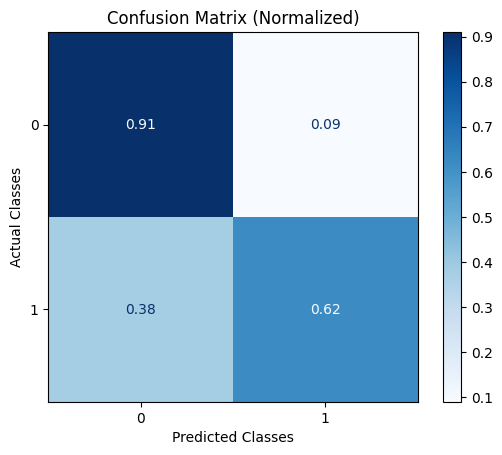

In [31]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
true_labels = df_balanced_["is_hallucination"].tolist()  # These are already 0 and 1
hallucination_classifications = df_balanced_["predictions"].tolist()
# Convert predictions from "yes"/"no" to 1/0
predicted_labels = [PREDICTION_MAP[pred] for pred in hallucination_classifications]

# Generate classification report
print(classification_report(true_labels, predicted_labels))

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# If you still want to use the ConfusionMatrix from pycm
from pycm import ConfusionMatrix

pycm_cm = ConfusionMatrix(actual_vector=true_labels, predict_vector=predicted_labels)
pycm_cm.plot(cmap=plt.colormaps["Blues"], number_label=True, normalized=True)

# SFT Model

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       100
           1       0.89      0.73      0.80       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

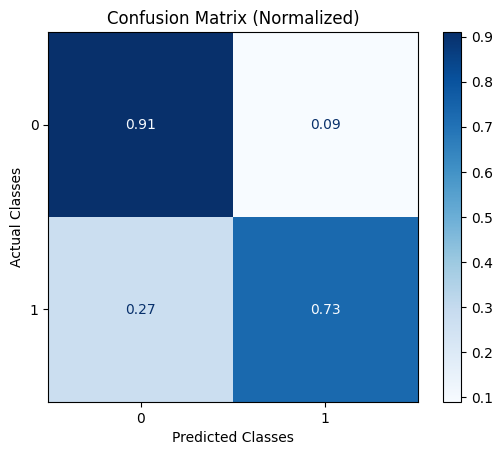

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
true_labels = df_balanced["is_hallucination"].tolist()  # These are already 0 and 1
hallucination_classifications = df_balanced["predictions"].tolist()
# Convert predictions from "yes"/"no" to 1/0
predicted_labels = [PREDICTION_MAP[pred] for pred in hallucination_classifications]

# Generate classification report
print(classification_report(true_labels, predicted_labels))

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# If you still want to use the ConfusionMatrix from pycm
from pycm import ConfusionMatrix

pycm_cm = ConfusionMatrix(actual_vector=true_labels, predict_vector=predicted_labels)
pycm_cm.plot(cmap=plt.colormaps["Blues"], number_label=True, normalized=True)